In [3]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
stations = pd.read_csv('../../data/target_three_stations_with_stats.csv')

In [27]:
stations[stations['station_name_roman'] == 'kokubunji']

,Unnamed: 0,station_cd,station_g_cd,station_name,station_name_k,station_name_r,line_cd,pref_cd,post,address,...,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
15,1519,1131224,1131106,国分寺,NaN,NaN,11312,13,185-0012,東京都国分寺市本町二丁目1-23,...,61.955089,809,238.489085,215.974381,41549.048454,20897.675696,1.06185,0.0,339,141.342307


In [28]:
stations[['station_name', 'line_cd', 'address', 'lat', 'lon']]

,station_name,line_cd,address,lat,lon
0,東京,11312,東京都千代田区丸の内一丁目,35.681391,139.766103
1,神田,11312,東京都千代田区鍛冶町二丁目13-1,35.691173,139.770641
2,御茶ノ水,11312,千代田区神田駿河台２丁目,35.699605,139.764955
3,四ツ谷,11312,東京都新宿区四谷一丁目,35.686041,139.730644
4,新宿,11312,東京都新宿区新宿三丁目38-1,35.689729,139.700464
...,...,...,...,...,...
98,栢山,25001,小田原市栢山,35.310679,139.142580
99,富水,25001,小田原市堀之内,35.296759,139.145166
100,螢田,25001,小田原市蓮正寺,35.285055,139.152036
101,足柄,25001,小田原市扇町３丁目,35.271763,139.154470


In [29]:
X_columns = ['n', 'm', 'k_avg', 'intersection_count',
       'streets_per_node_avg', 'edge_length_total', 'edge_length_avg',
       'street_length_total', 'street_length_avg', 'street_segments_count',
       'node_density_km', 'intersection_density_km', 'edge_density_km',
       'street_density_km', 'circuity_avg', 'self_loop_proportion',
       'clean_intersection_count', 'clean_intersection_density_km']
y_columns = ['line_cd']

In [30]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# データ分割
X = stations[X_columns]
y = stations[y_columns]
X_train = X
y_train = y
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 決定木クラスの初期化と学習
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
#print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.786


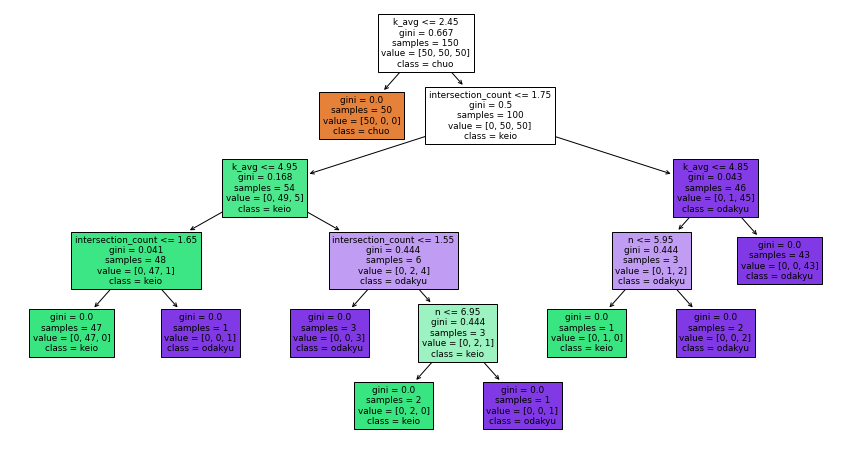

In [24]:
# 参考プログラム
from sklearn import tree
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
plot_tree(model, feature_names=X_columns, ax=ax, class_names=['chuo', 'keio', 'odakyu'], filled=True);


In [31]:
print(X_columns[14])
print(X_columns[4])

print(X_columns[5])
print(X_columns[8])
print(X_columns[17])
print(X_columns[2])
print(X_columns[3])

circuity_avg
streets_per_node_avg
edge_length_total
street_length_avg
clean_intersection_density_km
k_avg
intersection_count


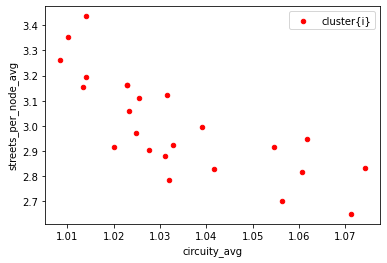

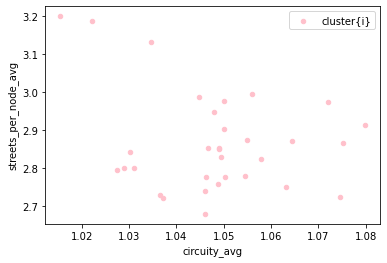

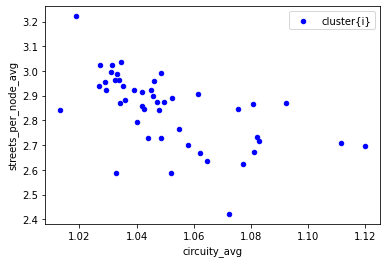

In [43]:
# 路線ごとの回路の平均数、交差点あたりの通り数の平均のグラフ化
ax = None
colors = {11312: 'red', 24001: 'pink', 25001: 'blue'}
for i, station in stations.groupby('line_cd'):
    station.plot.scatter(x='circuity_avg', y='streets_per_node_avg', color=colors[i], label='cluster{i}', ax=ax)
#    station.plot.scatter(x='k_avg', y='intersection_count', color=colors[i], label='cluster{i}', ax=ax)

In [44]:
# k-means法を使うためのインポート
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# データの列の絞り込み
stations_sub = stations[['circuity_avg','streets_per_node_avg']]
#stations_sub = stations[['k_avg','intersection_count']]

# 標準化
sc = StandardScaler()
sc.fit(stations_sub)
stations_sub_std = sc.transform(stations_sub)

0    24
1    17
2    62
Name: cluster_number, dtype: int64


Text(0, 0.5, 'count')

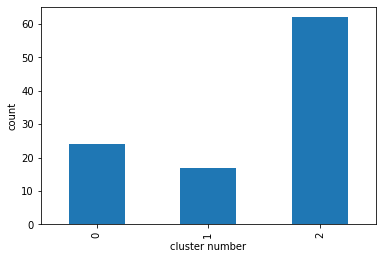

In [45]:
# KMeansクラスの初期化
kmeans = KMeans(init='random', n_clusters=3, random_state=0)

# クラスターの重心を計算
kmeans.fit(stations_sub_std)

# クラスター番号をpandasのSeriesオブジェクトに変換
labels = pd.Series(kmeans.labels_, name='cluster_number', index=stations.index)

# クラスター番号と件数を表示
print(labels.value_counts(sort=False))

# グラフを描画
ax = labels.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel('cluster number')
ax.set_ylabel('count')

In [46]:
# 駅のデータにクラスター番号のデータを結合
stations_with_cluster = pd.concat([stations, pd.Series(labels, index=stations.index)], axis=1)

# 先頭の5行を表示
stations_with_cluster.head()

,Unnamed: 0,station_cd,station_g_cd,station_name,station_name_k,station_name_r,line_cd,pref_cd,post,address,...,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km,cluster_number
0,1504,1131201,1130101,東京,NaN,NaN,11312,13,100-0005,東京都千代田区丸の内一丁目,...,680,189.211808,186.109975,26330.970417,22499.049783,1.014035,0.001250,239,105.905438,1
1,1505,1131202,1130223,神田,NaN,NaN,11312,13,101-0044,東京都千代田区鍛冶町二丁目13-1,...,1574,403.986454,398.583343,43598.513632,35685.441016,1.010215,0.000514,511,212.383825,1
2,1506,1131203,1131203,御茶ノ水,NaN,NaN,11312,13,101-0062,千代田区神田駿河台２丁目,...,1745,441.539940,430.401996,44360.780311,32394.428182,1.008452,0.000000,543,215.996565,1
3,1507,1131207,1131102,四ツ谷,NaN,NaN,11312,13,160-0004,東京都新宿区四谷一丁目,...,671,202.694435,170.001784,28946.199668,18123.142752,1.041690,0.000000,257,105.025141,2
4,1508,1131211,1130208,新宿,NaN,NaN,11312,13,160-0022,東京都新宿区新宿三丁目38-1,...,1093,295.499671,281.955936,36087.051021,24851.686072,1.022940,0.000000,396,162.524819,1


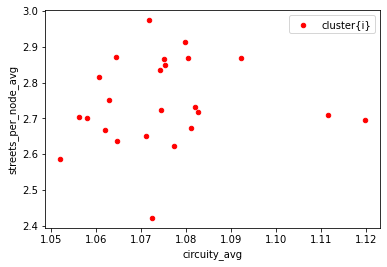

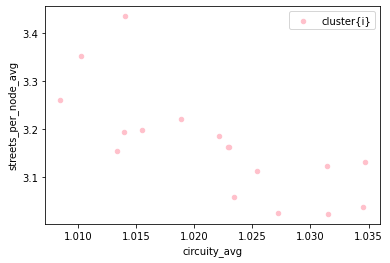

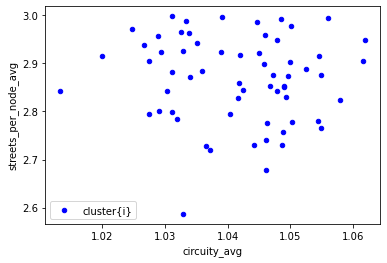

In [47]:
stations_0 = stations_with_cluster[stations_with_cluster['cluster_number'] == 0]
stations_1 = stations_with_cluster[stations_with_cluster['cluster_number'] == 1]
stations_2 = stations_with_cluster[stations_with_cluster['cluster_number'] == 2]
# クラスタリング結果のグラフ化
ax = None
colors = ['red', 'pink', 'blue']
for i, station in stations_with_cluster.groupby('cluster_number'):
#    station.plot.scatter(x='k_avg', y='streets_per_node_avg', color=colors[i], label='cluster{i}', ax=ax)
    station.plot.scatter(x='circuity_avg', y='streets_per_node_avg', color=colors[i], label='cluster{i}', ax=ax)

In [48]:
# クラスタ番号と路線を軸に集計し、路線を列に設定
cross_cluster_line_cd = stations_with_cluster.groupby(['cluster_number', 'line_cd']).size().unstack().fillna(0)
cross_cluster_line_cd

line_cd,11312,24001,25001
cluster_number,,,
0,4,6,14
1,10,3,4
2,10,23,29


<AxesSubplot:xlabel='line_cd', ylabel='cluster_number'>

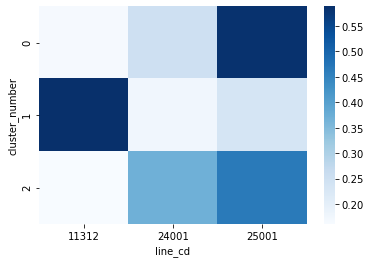

In [49]:
sns.heatmap(cross_cluster_line_cd.apply(lambda x : x/x.sum(), axis=1), cmap='Blues')

In [50]:
print([station['station_name'] for _, station in stations_with_cluster.iterrows() if (station['cluster_number'] == 0)])

['東小金井', '武蔵小金井', '西国分寺', '高尾', '八幡山', '分倍河原', '中河原', '聖蹟桜ヶ丘', '百草園', '南平', '生田', '読売ランド前', '百合ヶ丘', '新百合ヶ丘', '柿生', '鶴川', '玉川学園前', '鶴巻温泉', '東海大学前', '秦野', '渋沢', '新松田', '足柄', '小田原']


In [51]:
print([station['station_name'] for _, station in stations_with_cluster.iterrows() if (station['cluster_number'] == 1)])

['東京', '神田', '御茶ノ水', '新宿', '西荻窪', '三鷹', '立川', '豊田', '八王子', '西八王子', '新宿', '府中', '京王八王子', '新宿', '南新宿', '豪徳寺', '町田']


In [52]:
print([station['station_name'] for _, station in stations_with_cluster.iterrows() if (station['cluster_number'] == 2)])

['四ツ谷', '中野', '高円寺', '阿佐ケ谷', '荻窪', '吉祥寺', '武蔵境', '国分寺', '国立', '日野', '笹塚', '代田橋', '明大前', '下高井戸', '桜上水', '上北沢', '芦花公園', '千歳烏山', '仙川', 'つつじヶ丘', '柴崎', '国領', '布田', '調布', '西調布', '飛田給', '武蔵野台', '多磨霊園', '東府中', '高幡不動', '平山城址公園', '長沼', '北野', '参宮橋', '代々木八幡', '代々木上原', '東北沢', '下北沢', '世田谷代田', '梅ヶ丘', '経堂', '千歳船橋', '祖師ヶ谷大蔵', '成城学園前', '喜多見', '狛江', '和泉多摩川', '登戸', '向ヶ丘遊園', '相模大野', '小田急相模原', '相武台前', '座間', '海老名', '厚木', '本厚木', '愛甲石田', '伊勢原', '開成', '栢山', '富水', '螢田']
